In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import flowjax
from flowjax.bijections import Affine, Chain, Invert, RationalQuadraticSpline, Tanh
from flowjax.bijections.utils import Identity, Reshape
from flowjax.distributions import Normal, Transformed, Uniform, AbstractTransformed, AbstractDistribution, _StandardUniform, AbstractBijection
from flowjax.flows import masked_autoregressive_flow, coupling_flow
from flowjax.train import fit_to_data
from flowjax._custom_types import ArrayLike
from flowjax.wrappers import NonTrainable, Where
from typing import ClassVar
import equinox as eqx
from flowjax.masks import rank_based_mask
from collections.abc import Callable
import jax.nn as jnn

In [2]:
from __future__ import annotations

from collections.abc import Callable
from functools import partial

import jax.nn as jnn
from jax import Array
from jax.typing import ArrayLike

from flowjax.bijections.jax_transforms import Vmap
from flowjax.utils import get_ravelled_pytree_constructor
from flowjax.utils import arraylike_to_array, get_ravelled_pytree_constructor
from flowjax import wrappers

In [3]:

from equinox.nn import Linear
from jax.nn.initializers import glorot_uniform

from flowjax.bijections import (
    AbstractBijection,
    AdditiveCondition,
    Affine,
    BlockAutoregressiveNetwork,
    Chain,
    Concatenate,
    Coupling,
    Flip,
    Invert,
    LeakyTanh,
    Loc,
    MaskedAutoregressive,
    Permute,
    Planar,
    RationalQuadraticSpline,
    Scan,
    SoftPlus,
    Stack,
    TriangularAffine,
    Vmap,
)

from flowjax.bijections.masked_autoregressive import masked_autoregressive_mlp
from flowjax.distributions import AbstractDistribution, Transformed
from flowjax.wrappers import BijectionReparam, NonTrainable, WeightNormalization

# Mask playground

In [4]:
dim = 3 # z dimension or input dimension
nn_width = 5 # k or s
mlp_depth = 1
num_params = 1

in_ranks = jnp.arange(dim)
hidden_ranks = jnp.arange(nn_width) % dim
# out_ranks = jnp.repeat(jnp.arange(dim), num_params)
out_ranks = jnp.repeat(jnp.arange(dim), num_params)

In [72]:
# Forms mask matrix, with 1s where the out_ranks > or >= in_ranks

In [73]:
in_ranks

Array([0, 1, 2], dtype=int32)

In [74]:
out_ranks

Array([0, 1, 2], dtype=int32)

In [75]:
mlp = eqx.nn.MLP(
    key=jr.PRNGKey(7),
    in_size=len(in_ranks),
    out_size=len(out_ranks),
    width_size=len(hidden_ranks),
    depth=mlp_depth,
)

In [76]:
ranks = [in_ranks, *[hidden_ranks] * mlp.depth, out_ranks]

In [77]:
i = 0
mlp.layers[i]

Linear(
  weight=f32[5,3],
  bias=f32[5],
  in_features=3,
  out_features=5,
  use_bias=True
)

In [78]:
mask0 = rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
mask0

Array([[ True, False, False],
       [ True,  True, False],
       [ True,  True,  True],
       [ True, False, False],
       [ True,  True, False]], dtype=bool)

In [79]:
i = 1

mlp.layers[i]

Linear(
  weight=f32[3,5],
  bias=f32[3],
  in_features=5,
  out_features=3,
  use_bias=True
)

In [84]:
mask1 =rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
mask1

Array([[False, False, False, False, False],
       [ True, False, False,  True, False],
       [ True,  True, False,  True,  True]], dtype=bool)

In [81]:
mask0.shape, mask1.shape

((5, 3), (3, 5))

In [82]:
(mask1.astype(int))@(mask0.astype(int))

Array([[0, 0, 0],
       [2, 0, 0],
       [4, 2, 0]], dtype=int32)

In [83]:
mask1@mask0

Array([[False, False, False],
       [ True, False, False],
       [ True,  True, False]], dtype=bool)

In [181]:
masked_layers = []
for i, linear in enumerate(mlp.layers):
    if i ==0:
        mask = jnp.zeros((nn_width, dim))
    else:
        mask = rank_based_mask(ranks[i], ranks[i + 1], eq=i != len(mlp.layers) - 1)
    masked_linear = eqx.tree_at(
        lambda linear: linear.weight, linear, Where(mask, linear.weight, 0)
    )
    masked_layers.append(masked_linear)

In [67]:
masked_layers

[Linear(
   weight=Where(cond=bool[5,3], if_true=f32[5,3], if_false=0),
   bias=f32[5],
   in_features=3,
   out_features=5,
   use_bias=True
 ),
 Linear(
   weight=Where(cond=bool[5,5], if_true=f32[5,5], if_false=0),
   bias=f32[5],
   in_features=5,
   out_features=5,
   use_bias=True
 ),
 Linear(
   weight=Where(cond=bool[5,5], if_true=f32[5,5], if_false=0),
   bias=f32[5],
   in_features=5,
   out_features=5,
   use_bias=True
 ),
 Linear(
   weight=Where(cond=bool[5,5], if_true=f32[5,5], if_false=0),
   bias=f32[5],
   in_features=5,
   out_features=5,
   use_bias=True
 ),
 Linear(
   weight=Where(cond=bool[93,5], if_true=f32[93,5], if_false=0),
   bias=f32[93],
   in_features=5,
   out_features=93,
   use_bias=True
 )]

# Masked independent flow

In [5]:
def masked_independent_mlp(
    in_ranks: ArrayLike,
    hidden_ranks: ArrayLike,
    out_ranks: ArrayLike,
    **kwargs,
) -> eqx.nn.MLP:
    """Returns an equinox multilayer perceptron, with autoregressive masks.

    The weight matrices are wrapped using :class:`~flowjax.wrappers.Where`, which
    will apply the masking when :class:`~flowjax.wrappers.unwrap` is called on the MLP.
    For details of how the masks are formed, see https://arxiv.org/pdf/1502.03509.pdf.

    Args:
        in_ranks: The ranks of the inputs.
        hidden_ranks: The ranks of the hidden dimensions.
        out_ranks: The ranks of the output dimensions.
        **kwargs: Keyword arguments passed to equinox.nn.MLP.
    """
    in_ranks, hidden_ranks, out_ranks = (
        jnp.asarray(a, jnp.int32) for a in (in_ranks, hidden_ranks, out_ranks)
    )
    mlp = eqx.nn.MLP(
        in_size=len(in_ranks),
        out_size=len(out_ranks),
        width_size=len(hidden_ranks),
        **kwargs,
    )
    ranks = [in_ranks, *[hidden_ranks] * mlp.depth, out_ranks]

    masked_layers = []
    for i, linear in enumerate(mlp.layers):
        if i == 0:
            mask = jnp.zeros((mlp.width_size, mlp.in_size))
            masked_linear = eqx.tree_at(
                lambda linear: linear.weight, linear, Where(mask, linear.weight, 0)
            )
        else:
            masked_linear = linear
        masked_layers.append(masked_linear)

    return eqx.tree_at(lambda mlp: mlp.layers, mlp, replace=tuple(masked_layers))

In [6]:
class MaskedIndependent(AbstractBijection):
    """Masked autoregressive bijection.

    The transformer is parameterised by a neural network, with weights masked to ensure
    an autoregressive structure.

    Refs:
        - https://arxiv.org/abs/1705.07057v4
        - https://arxiv.org/abs/1705.07057v4

    Args:
        key: Jax PRNGKey
        transformer: Bijection with shape () to be parameterised by the autoregressive
            network. Parameters wrapped with ``NonTrainable`` are exluded.
        dim: Dimension.
        cond_dim: Dimension of any conditioning variables. Defaults to None.
        nn_width: Neural network width.
        nn_depth: Neural network depth.
        nn_activation: Neural network activation. Defaults to jnn.relu.
    """

    shape: tuple[int, ...]
    cond_shape: tuple[int, ...] | None
    transformer_constructor: Callable
    masked_independent_mlp: eqx.nn.MLP

    def __init__(
        self,
        key: Array,
        *,
        transformer: AbstractBijection,
        dim: int,
        cond_dim: int | None = None,
        nn_width: int,
        nn_depth: int,
        nn_activation: Callable = jnn.relu,
    ) -> None:
        if transformer.shape != () or transformer.cond_shape is not None:
            raise ValueError(
                "Only unconditional transformers with shape () are supported.",
            )

        constructor, num_params = get_ravelled_pytree_constructor(transformer)

        if cond_dim is None:
            self.cond_shape = None
            in_ranks = jnp.arange(dim)
        else:
            self.cond_shape = (cond_dim,)
            # we give conditioning variables rank -1 (no masking of edges to output)
            in_ranks = jnp.hstack((jnp.arange(dim), -jnp.ones(cond_dim)))

        hidden_ranks = jnp.arange(nn_width) % dim
        out_ranks = jnp.repeat(jnp.arange(dim), num_params)

        self.masked_independent_mlp = masked_independent_mlp(
            in_ranks,
            hidden_ranks,
            out_ranks,
            depth=nn_depth,
            activation=nn_activation,
            key=key,
        )

        self.transformer_constructor = constructor
        self.shape = (dim,)
        self.cond_shape = None if cond_dim is None else (cond_dim,)

    def transform(self, x, condition=None):
        nn_input = x if condition is None else jnp.hstack((x, condition))
        transformer_params = self.masked_independent_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        return transformer.transform(x)

    def transform_and_log_det(self, x, condition=None):
        nn_input = x if condition is None else jnp.hstack((x, condition))
        transformer_params = self.masked_independent_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        return transformer.transform_and_log_det(x)

    def inverse(self, y, condition=None):
        init = (y, 0)
        fn = partial(self.inv_scan_fn, condition=condition)
        (x, _), _ = jax.lax.scan(fn, init, None, length=len(y))
        return x

    def inv_scan_fn(self, init, _, condition):
        """One 'step' in computing the inverse."""
        y, rank = init
        nn_input = y if condition is None else jnp.hstack((y, condition))
        transformer_params = self.masked_independent_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        x = transformer.inverse(y)
        x = y.at[rank].set(x[rank])
        return (x, rank + 1), None

    def inverse_and_log_det(self, y, condition=None):
        x = self.inverse(y, condition)
        log_det = self.transform_and_log_det(x, condition)[1]
        return x, -log_det

    def _flat_params_to_transformer(self, params: Array):
        """Reshape to dim X params_per_dim, then vmap."""
        dim = self.shape[-1]
        transformer_params = jnp.reshape(params, (dim, -1))
        transformer = eqx.filter_vmap(self.transformer_constructor)(transformer_params)
        return Vmap(transformer, in_axes=eqx.if_array(0))


In [7]:
def masked_independent_flow(
    key: Array,
    *,
    base_dist: AbstractDistribution,
    transformer: AbstractBijection | None = None,
    cond_dim: int | None = None,
    flow_layers: int = 8,
    nn_width: int = 50,
    nn_depth: int = 1,
    nn_activation: Callable = jnn.relu,
    invert: bool = True,
) -> Transformed:
    """Masked autoregressive flow.

    Parameterises a transformer bijection with an autoregressive neural network.
    Refs: https://arxiv.org/abs/1606.04934; https://arxiv.org/abs/1705.07057v4.

    Args:
        key: Random seed.
        base_dist: Base distribution, with ``base_dist.ndim==1``.
        transformer: Bijection parameterised by autoregressive network. Defaults to
            affine.
        cond_dim: Dimension of the conditioning variable. Defaults to None.
        flow_layers: Number of flow layers. Defaults to 8.
        nn_width: Number of hidden layers in neural network. Defaults to 50.
        nn_depth: Depth of neural network. Defaults to 1.
        nn_activation: _description_. Defaults to jnn.relu.
        invert: Whether to invert the bijection. Broadly, True will prioritise a faster
            inverse, leading to faster `log_prob`, False will prioritise faster forward,
            leading to faster `sample`. Defaults to True.
    """
    if transformer is None:
        transformer = eqx.tree_at(
            lambda aff: aff.scale,
            Affine(),
            BijectionReparam(1, Chain([SoftPlus(), NonTrainable(Loc(1e-2))])),
        )
    dim = base_dist.shape[-1]

    def make_layer(key):  # masked autoregressive layer + permutation
        bij_key, perm_key = jr.split(key)
        bijection = MaskedIndependent(
            key=bij_key,
            transformer=transformer,
            dim=dim,
            cond_dim=cond_dim,
            nn_width=nn_width,
            nn_depth=nn_depth,
            nn_activation=nn_activation,
        )
        return _add_default_permute(bijection, dim, perm_key)

    keys = jr.split(key, flow_layers)
    layers = eqx.filter_vmap(make_layer)(keys)
    bijection = Invert(Scan(layers)) if invert else Scan(layers)
    return Transformed(base_dist, bijection)

In [8]:
def _add_default_permute(bijection: AbstractBijection, dim: int, key: Array):
    if dim == 1:
        return bijection
    if dim == 2:
        return Chain([bijection, Flip((dim,))]).merge_chains()

    perm = Permute(jr.permutation(key, jnp.arange(dim)))
    return Chain([bijection, perm]).merge_chains()

 30%|███████████████████████████▌                                                                | 21/70 [00:11<00:26,  1.86it/s, train=2.8401897, val=2.8768137 (Max patience reached)]


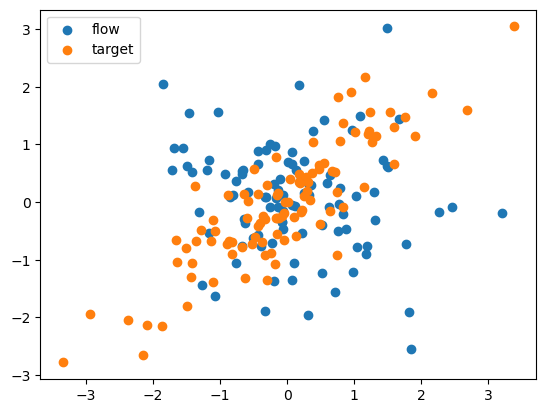

In [9]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(0))
# x = jr.normal(subkey, shape=(5000, nvars))  
x = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))
base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

flow = masked_independent_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

flow = Transformed(
    flow, Invert(Tanh(flow.shape))
) # Unbounded support


flow = flow.merge_transforms()

assert isinstance(flow.base_dist, _StandardUniform)

flow = eqx.tree_at(
    where=lambda flow: flow.bijection.bijections[0],
    pytree=flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
flow, losses = fit_to_data(
    key=subkey,
    dist=flow,
    x=x,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*flow.sample(key, (100, )).T, label="flow")
plt.scatter(*x[:100].T, label="target")
plt.legend()

In [10]:
flow.bijection.inverse(x[0])

Array([0.57677144, 0.6285392 ], dtype=float32)

In [11]:
marginal_cdf = jax.vmap(flow.bijection.inverse, in_axes=(0,))

In [12]:
u_x = marginal_cdf(x)

In [25]:
# from scipy.stats import norm
plt.scatter(*(burh(x).T), label="inverse flow", s=2,)
# plt.scatter(*x[:100].T, label="target")
plt.legend()

NameError: name 'burh' is not defined

In [59]:
import scipy
scipy.stats.spearmanr(burh(x).T[0], burh(x).T[1])

SignificanceResult(statistic=0.7780607397571232, pvalue=0.0)

In [57]:
from scipy.stats import norm
norm.ppf(burh(x).T)


array([[ 0.19364083,  1.70081711,  0.71870613, ...,  0.54467535,
         0.84311956, -0.10302389],
       [ 0.32798687,  1.47126889,  0.48002452, ...,  0.30953357,
         0.92904741,  0.36370918]])

# Copula flows given marginal

 63%|███████████████████████████████████████████████████████▉                                 | 44/70 [00:12<00:07,  3.39it/s, train=-0.5076147, val=-0.45399386 (Max patience reached)]


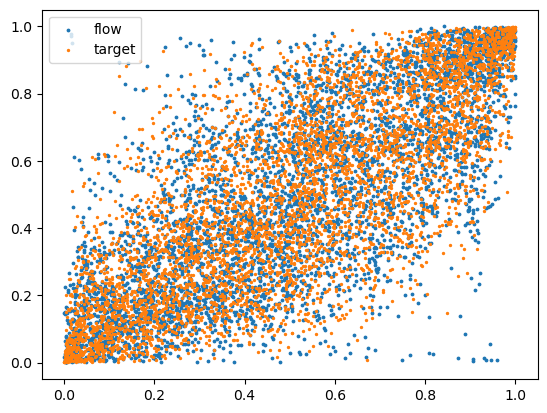

In [13]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(0))

base_dist = Uniform(-jnp.ones(nvars), jnp.ones(nvars))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars), scale=jnp.ones(nvars)*2))
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-1],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=u_x,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
)

plt.scatter(*copula_flow.sample(key, (5000, )).T, label="flow", s=3)
plt.scatter(*u_x.T, label="target", s=2)
plt.legend()

In [14]:
inv_copula_cdf = jax.vmap(copula_flow.bijection.inverse, in_axes=(0,))

In [15]:
u = inv_copula_cdf(u_x)

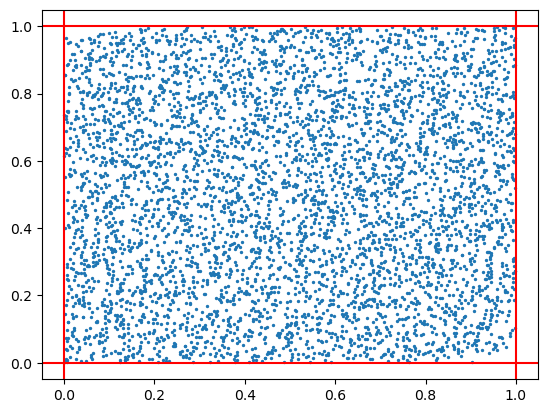

In [16]:
# from scipy.stats import norm
plt.scatter(*(u.T), label="inverse flow", s=2,)
plt.axhline(0, color='red')
plt.axhline(1, color='red')
plt.axvline(0, color='red')
plt.axvline(1, color='red')



# copula flow + marginal Y|do(X) given other marginals

In [27]:
# # make it an Affine subclass
# class Identity(AbstractBijection):
#     """Elementwise affine transformation ``y = a*x + b``.

#     ``loc`` and ``scale`` should broadcast to the desired shape of the bijection.
#     By default, we constrain the scale parameter to be postive using ``SoftPlus``, but
#     other parameterizations can be achieved by replacing the scale parameter after
#     construction e.g. using ``eqx.tree_at``.

#     Args:
#         loc: Location parameter. Defaults to 0.
#         scale: Scale parameter. Defaults to 1.
#     """

#     shape: tuple[int, ...]
#     cond_shape: ClassVar[None] = None

#     def __init__(
#         self,
#         shape,
#     ):
#         self.shape = shape



#     def transform(self, x, condition=None):
#         return x 

#     def transform_and_log_det(self, x, condition=None):
#         return x, 0.

#     def inverse(self, y, condition=None):
#         return y

#     def inverse_and_log_det(self, y, condition=None):
#         return y, 0.

In [12]:
class Univariate_Normal_CDF(AbstractBijection):
    """Elementwise affine transformation ``y = a*x + b``.

    ``loc`` and ``scale`` should broadcast to the desired shape of the bijection.
    By default, we constrain the scale parameter to be postive using ``SoftPlus``, but
    other parameterizations can be achieved by replacing the scale parameter after
    construction e.g. using ``eqx.tree_at``.

    Args:
        loc: Location parameter. Defaults to 0.
        scale: Scale parameter. Defaults to 1.
    """

    shape: tuple[int, ...]
    cond_shape: ClassVar[None] = None
    ate: Array
    scale: Array | wrappers.AbstractUnwrappable[Array]

    def __init__(
        self,
        ate: ArrayLike = 0,
        scale: ArrayLike = 1,
    ):
        self.ate, scale = jnp.broadcast_arrays(
            *(arraylike_to_array(a, dtype=float) for a in (ate, scale)),
        )
        self.shape =  scale.shape #(1,)
        self.scale = scale # wrappers.BijectionReparam(scale, SoftPlus()) #why not constraining it to be inputted as positive??

    def transform(self, x, condition=None):
        location_x = self.ate*condition[0] if (condition is not None) else self.ate
        return jax.scipy.stats.norm.cdf(x, loc=location_x, scale=self.scale)
        # return x * self.scale + self.loc

    def transform_and_log_det(self, x, condition=None):
        location_x = self.ate*condition[0] if (condition is not None) else self.ate
        transformed_x = jax.scipy.stats.norm.cdf(x, loc=location_x, scale=self.scale)
        log_det_x = jax.scipy.stats.norm.logpdf(x, loc=location_x, scale=self.scale)
        return transformed_x, log_det_x

    def inverse(self, y, condition=None):
        location_y = self.ate*condition[0] if (condition is not None) else self.ate
        return jax.scipy.special.ndtri(y)*self.scale + location_y

    def inverse_and_log_det(self, y, condition=None):
        location_y = self.ate*condition[0] if (condition is not None) else self.ate
        inverse_y = jax.scipy.special.ndtri(y)*self.scale + location_y
        log_det_y = -jax.scipy.stats.norm.logpdf(inverse_y, loc=location_y, scale=self.scale)
        return inverse_y, log_det_y

In [13]:
# gen data
# y = jr.normal(subkey, shape=(5000,1))

key, subkey = jr.split(jr.PRNGKey(0))

# x = jr.bernoulli(subkey, p=0.5, shape=(5000, 1))
# # x = jr.multivariate_normal(key, jnp.array([0.,0.]), jnp.array([[1., 0.8],[0.8, 1.]]), shape=(5000,))

key, subkey = jr.split(key)
y = jr.normal(subkey, shape=(5000,1)) #+ x

y.shape, x.shape

list_bijections = [Univariate_Normal_CDF(ate=5., scale=2.)] + [Identity(())]*2  


marginal_transform = Stack(list_bijections)

In [14]:
def masked_autoregressive_flow_but_first(
    key: Array,
    *,
    base_dist: AbstractDistribution,
    transformer: AbstractBijection | None = None,
    cond_dim: int | None = None,
    flow_layers: int = 8,
    nn_width: int = 50,
    nn_depth: int = 1,
    nn_activation: Callable = jnn.relu,
    invert: bool = True,
) -> Transformed:
    """Masked autoregressive flow.

    Parameterises a transformer bijection with an autoregressive neural network.
    Refs: https://arxiv.org/abs/1606.04934; https://arxiv.org/abs/1705.07057v4.

    Args:
        key: Random seed.
        base_dist: Base distribution, with ``base_dist.ndim==1``.
        transformer: Bijection parameterised by autoregressive network. Defaults to
            affine.
        cond_dim: Dimension of the conditioning variable. Defaults to None.
        flow_layers: Number of flow layers. Defaults to 8.
        nn_width: Number of hidden layers in neural network. Defaults to 50.
        nn_depth: Depth of neural network. Defaults to 1.
        nn_activation: _description_. Defaults to jnn.relu.
        invert: Whether to invert the bijection. Broadly, True will prioritise a faster
            inverse, leading to faster `log_prob`, False will prioritise faster forward,
            leading to faster `sample`. Defaults to True.
    """
    if transformer is None:
        transformer = eqx.tree_at(
            lambda aff: aff.scale,
            Affine(),
            BijectionReparam(1, Chain([SoftPlus(), NonTrainable(Loc(1e-2))])),
        )
    dim = base_dist.shape[-1]

    def make_layer(key):  # masked autoregressive layer + permutation
        bij_key, perm_key = jr.split(key)
        bijection = MaskedAutoregressive(
            key=bij_key,
            transformer=transformer,
            dim=dim,
            cond_dim=cond_dim,
            nn_width=nn_width,
            nn_depth=nn_depth,
            nn_activation=nn_activation,
        )
        return bijection
        # return _add_default_permute_but_first(bijection, dim, perm_key)

    keys = jr.split(key, flow_layers)
    layers = eqx.filter_vmap(make_layer)(keys)
    bijection = Invert(Scan(layers)) if invert else Scan(layers)
    return Transformed(base_dist, bijection)

In [15]:

def masked_autoregressive_flow_cond_uniform(
    key: Array,
    *,
    base_dist: AbstractDistribution,
    transformer: AbstractBijection | None = None,
    cond_dim: int | None = None,
    cond_u_y_dim: int = 1,
    flow_layers: int = 8,
    nn_width: int = 50,
    nn_depth: int = 1,
    nn_activation: Callable = jnn.relu,
    invert: bool = True,
) -> Transformed:
    """Masked autoregressive flow.

    Parameterises a transformer bijection with an autoregressive neural network.
    Refs: https://arxiv.org/abs/1606.04934; https://arxiv.org/abs/1705.07057v4.

    Args:
        key: Random seed.
        base_dist: Base distribution, with ``base_dist.ndim==1``.
        transformer: Bijection parameterised by autoregressive network. Defaults to
            affine.
        cond_dim: Dimension of the conditioning variable. Defaults to None.
        flow_layers: Number of flow layers. Defaults to 8.
        nn_width: Number of hidden layers in neural network. Defaults to 50.
        nn_depth: Depth of neural network. Defaults to 1.
        nn_activation: _description_. Defaults to jnn.relu.
        invert: Whether to invert the bijection. Broadly, True will prioritise a faster
            inverse, leading to faster `log_prob`, False will prioritise faster forward,
            leading to faster `sample`. Defaults to True.
    """
    if transformer is None:
        transformer = eqx.tree_at(
            lambda aff: aff.scale,
            Affine(),
            BijectionReparam(1, Chain([SoftPlus(), NonTrainable(Loc(1e-2))])),
        )
    dim = base_dist.shape[-1]

    assert cond_dim >= cond_u_y_dim

    def make_layer(key):  # masked autoregressive layer + permutation
        bij_key, perm_key = jr.split(key)
        list_bijections = [Identity((cond_u_y_dim,))]
        MAF_bijection = MaskedAutoregressive(
            key=bij_key,
            transformer=transformer,
            dim=dim-cond_u_y_dim,
            cond_dim=cond_dim,
            nn_width=nn_width,
            nn_depth=nn_depth,
            nn_activation=nn_activation,
        )
        list_bijections.append(MAF_bijection)
        bijection = Concatenate(list_bijections)
        return _add_default_permute_but_first(bijection, dim, perm_key)

    keys = jr.split(key, flow_layers)
    layers = eqx.filter_vmap(make_layer)(keys)
    bijection = Invert(Scan(layers)) if invert else Scan(layers)
    return Transformed(base_dist, bijection)

In [305]:
class MaskedAutoregressiveSuccess(AbstractBijection):
    """Masked autoregressive bijection.

    The transformer is parameterised by a neural network, with weights masked to ensure
    an autoregressive structure.

    Refs:
        - https://arxiv.org/abs/1705.07057v4
        - https://arxiv.org/abs/1705.07057v4

    Args:
        key: Jax PRNGKey
        transformer: Bijection with shape () to be parameterised by the autoregressive
            network. Parameters wrapped with ``NonTrainable`` are exluded.
        dim: Dimension.
        cond_dim: Dimension of any conditioning variables. Defaults to None.
        nn_width: Neural network width.
        nn_depth: Neural network depth.
        nn_activation: Neural network activation. Defaults to jnn.relu.
    """

    shape: tuple[int, ...]
    cond_shape: tuple[int, ...] | None
    transformer_constructor: Callable
    masked_autoregressive_mlp: eqx.nn.MLP

    def __init__(
        self,
        key: Array,
        *,
        transformer: AbstractBijection,
        dim: int,
        cond_dim: int | None = None,
        nn_width: int,
        nn_depth: int,
        nn_activation: Callable = jnn.relu,
    ) -> None:
        if transformer.shape != () or transformer.cond_shape is not None:
            raise ValueError(
                "Only unconditional transformers with shape () are supported.",
            )

        constructor, num_params = get_ravelled_pytree_constructor(transformer)

        if cond_dim is None:
            self.cond_shape = None
            in_ranks = jnp.arange(dim)
        else:
            self.cond_shape = (cond_dim,)
            # we give conditioning variables rank -1 (no masking of edges to output)
            in_ranks = jnp.hstack((jnp.arange(dim), -jnp.ones(cond_dim)))

        hidden_ranks = jnp.arange(nn_width) % dim
        out_ranks = jnp.repeat(jnp.arange(dim), num_params)

        self.masked_autoregressive_mlp = masked_autoregressive_mlp(
            in_ranks,
            hidden_ranks,
            out_ranks,
            depth=nn_depth,
            activation=nn_activation,
            key=key,
        )

        self.transformer_constructor = constructor
        self.shape = (dim,)
        self.cond_shape = None if cond_dim is None else (cond_dim,)

    def transform(self, x, condition=None):
        nn_input = x if condition is None else jnp.hstack((x, condition))
        transformer_params = self.masked_autoregressive_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        return transformer.transform(x)

    def transform_and_log_det(self, x, condition=None):
        nn_input = x if condition is None else jnp.hstack((x, condition))
        transformer_params = self.masked_autoregressive_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        return transformer.transform_and_log_det(x)

    def inverse(self, y, condition=None):
        init = (y, 0)
        fn = partial(self.inv_scan_fn, condition=condition)
        (x, _), _ = jax.lax.scan(fn, init, None, length=len(y))
        return x

    def inv_scan_fn(self, init, _, condition):
        """One 'step' in computing the inverse."""
        y, rank = init
        nn_input = y if condition is None else jnp.hstack((y, condition))
        transformer_params = self.masked_autoregressive_mlp(nn_input)
        transformer = self._flat_params_to_transformer(transformer_params)
        x = transformer.inverse(y)
        x = y.at[rank].set(x[rank])
        return (x, rank + 1), None

    def inverse_and_log_det(self, y, condition=None):
        x = self.inverse(y, condition)
        log_det = self.transform_and_log_det(x, condition)[1]
        return x, -log_det


    def _flat_params_to_transformer(self, params: Array, cond_u_y_dim=1):
        """Reshape to dim X params_per_dim, then vmap."""
        dim = self.shape[-1]
        transformer_params = jnp.reshape(params, (dim, -1))
        transformer_params = transformer_params[cond_u_y_dim:, :]
        transformer = eqx.filter_vmap(self.transformer_constructor)(transformer_params)
        return Concatenate([Identity((cond_u_y_dim,)), Vmap(transformer, in_axes=eqx.if_array(0))])       
        # return Vmap(transformer, in_axes=eqx.if_array(0))


    # def _flat_params_to_transformer(self, params: Array):
    #     """Reshape to dim X params_per_dim, then vmap."""
    #     dim = self.shape[-1]
    #     transformer_params = jnp.reshape(params, (dim, -1))
    #     transformer = eqx.filter_vmap(self.transformer_constructor)(transformer_params)
    #     return Vmap(transformer, in_axes=eqx.if_array(0))

In [306]:

def masked_autoregressive_flow_success(
    key: Array,
    *,
    base_dist: AbstractDistribution,
    transformer: AbstractBijection | None = None,
    cond_dim: int | None = None,
    cond_u_y_dim: int = 1,
    flow_layers: int = 8,
    nn_width: int = 50,
    nn_depth: int = 1,
    nn_activation: Callable = jnn.relu,
    invert: bool = True,
) -> Transformed:
    """Masked autoregressive flow.

    Parameterises a transformer bijection with an autoregressive neural network.
    Refs: https://arxiv.org/abs/1606.04934; https://arxiv.org/abs/1705.07057v4.

    Args:
        key: Random seed.
        base_dist: Base distribution, with ``base_dist.ndim==1``.
        transformer: Bijection parameterised by autoregressive network. Defaults to
            affine.
        cond_dim: Dimension of the conditioning variable. Defaults to None.
        flow_layers: Number of flow layers. Defaults to 8.
        nn_width: Number of hidden layers in neural network. Defaults to 50.
        nn_depth: Depth of neural network. Defaults to 1.
        nn_activation: _description_. Defaults to jnn.relu.
        invert: Whether to invert the bijection. Broadly, True will prioritise a faster
            inverse, leading to faster `log_prob`, False will prioritise faster forward,
            leading to faster `sample`. Defaults to True.
    """
    if transformer is None:
        transformer = eqx.tree_at(
            lambda aff: aff.scale,
            Affine(),
            BijectionReparam(1, Chain([SoftPlus(), NonTrainable(Loc(1e-2))])),
        )
    dim = base_dist.shape[-1]

    # assert cond_dim >= cond_u_y_dim

    def make_layer(key):  # masked autoregressive layer + permutation
        bij_key, perm_key = jr.split(key)
        list_bijections = [Identity((cond_u_y_dim,))]
        MAF_bijection = MaskedAutoregressiveSuccess(
            key=bij_key,
            transformer=transformer,
            dim=dim-cond_u_y_dim,
            cond_dim=cond_dim,
            nn_width=nn_width,
            nn_depth=nn_depth,
            nn_activation=nn_activation,
        )
        list_bijections.append(MAF_bijection)
        bijection = Concatenate(list_bijections)
        return _add_default_permute_but_first(bijection, dim, perm_key)

    keys = jr.split(key, flow_layers)
    layers = eqx.filter_vmap(make_layer)(keys)
    bijection = Invert(Scan(layers)) if invert else Scan(layers)
    return Transformed(base_dist, bijection)

In [307]:
MAF_bijection = MaskedAutoregressive(
            key=key,
            transformer=transformer,
            dim=3-1,
            cond_dim=1,
            nn_width=8,
            nn_depth=50,
            nn_activation=1,
        )

In [308]:
rr = Reshape(MAF_bijection, (1,2))
rr.shape

(1, 2)

In [366]:
ii = Reshape(Identity((1,)), (1,1))
ii.shape

(1, 1)

In [371]:
Concatenate([Identity((1,)), MAF_bijection])

Concatenate(
  shape=(3,),
  cond_shape=(1,),
  split_idxs=(1,),
  bijections=[
    Identity(shape=(1,)),
    MaskedAutoregressive(
      shape=(2,),
      cond_shape=(1,),
      transformer_constructor=<function constructor>,
      masked_autoregressive_mlp=MLP(
        layers=(
          Linear(
            weight=Where(cond=bool[8,3], if_true=f32[8,3], if_false=0),
            bias=f32[8],
            in_features=3,
            out_features=8,
            use_bias=True
          ),
          Linear(
            weight=Where(cond=bool[8,8], if_true=f32[8,8], if_false=0),
            bias=f32[8],
            in_features=8,
            out_features=8,
            use_bias=True
          ),
          Linear(
            weight=Where(cond=bool[8,8], if_true=f32[8,8], if_false=0),
            bias=f32[8],
            in_features=8,
            out_features=8,
            use_bias=True
          ),
          Linear(
            weight=Where(cond=bool[8,8], if_true=f32[8,8], if_false=0),
  

In [86]:
transformer

RationalQuadraticSpline(
  knots=8,
  interval=1,
  softmax_adjust=0.01,
  min_derivative=0.001,
  x_pos=Lambda(
    _dummy=f32[],
    fn=<wrapped function _real_to_increasing_on_interval>,
    args=(f32[8],),
    kwargs={}
  ),
  y_pos=Lambda(
    _dummy=f32[],
    fn=<wrapped function _real_to_increasing_on_interval>,
    args=(f32[8],),
    kwargs={}
  ),
  derivatives=Lambda(
    _dummy=f32[],
    fn=<function <lambda>>,
    args=(f32[10],),
    kwargs={}
  )
)

In [239]:
transformer = RationalQuadraticSpline(knots=8, interval=1)

In [240]:
# newtr = Stack([Identity(()), transformer])

In [241]:
constructor, spline_params = get_ravelled_pytree_constructor(transformer)
spline_params

29

In [242]:
constructor

<function flowjax.utils.get_ravelled_pytree_constructor.<locals>.constructor(ravelled_params: 'Array')>

In [243]:
# transformer_params = jnp.arange(29)
# transformer_params = jnp.reshape(transformer_params, (1, -1))

In [265]:
dim = 2

In [266]:
transformer_params = jnp.arange(29*dim)

In [267]:
transformer_params = jnp.reshape(transformer_params, (dim, -1))

In [268]:
transformer_params.shape

(2, 29)

In [278]:
# constructor_vmapped = Stack([Identity(()), eqx.filter_vmap(constructor)(transformer_params)])
# constructor_vmapped

In [279]:
constructor_vmapped = eqx.filter_vmap(constructor)(transformer_params)
constructor_vmapped

RationalQuadraticSpline(
  knots=8,
  interval=1,
  softmax_adjust=0.01,
  min_derivative=0.001,
  x_pos=Lambda(
    _dummy=f32[2],
    fn=<wrapped function _real_to_increasing_on_interval>,
    args=(f32[2,8],),
    kwargs={}
  ),
  y_pos=Lambda(
    _dummy=f32[2],
    fn=<wrapped function _real_to_increasing_on_interval>,
    args=(f32[2,8],),
    kwargs={}
  ),
  derivatives=Lambda(
    _dummy=f32[2],
    fn=<function <lambda>>,
    args=(f32[2,10],),
    kwargs={}
  )
)

In [280]:
constructor_vmapped.shape

()

In [284]:
Vmap(constructor_vmapped, in_axes=eqx.if_array(0))#.bijection.bijections[1]

Vmap(
  bijection=RationalQuadraticSpline(
    knots=8,
    interval=1,
    softmax_adjust=0.01,
    min_derivative=0.001,
    x_pos=Lambda(
      _dummy=f32[2],
      fn=<wrapped function _real_to_increasing_on_interval>,
      args=(f32[2,8],),
      kwargs={}
    ),
    y_pos=Lambda(
      _dummy=f32[2],
      fn=<wrapped function _real_to_increasing_on_interval>,
      args=(f32[2,8],),
      kwargs={}
    ),
    derivatives=Lambda(
      _dummy=f32[2],
      fn=<function <lambda>>,
      args=(f32[2,10],),
      kwargs={}
    )
  ),
  in_axes=(if_array(axis=0), 0, None),
  axis_size=2,
  cond_shape=None
)

In [289]:
Concatenate([Identity((1,)), Vmap(constructor_vmapped, in_axes=eqx.if_array(0))])

Concatenate(
  shape=(3,),
  cond_shape=None,
  split_idxs=(1,),
  bijections=[
    Identity(shape=(1,)),
    Vmap(
      bijection=RationalQuadraticSpline(
        knots=8,
        interval=1,
        softmax_adjust=0.01,
        min_derivative=0.001,
        x_pos=Lambda(
          _dummy=f32[2],
          fn=<wrapped function _real_to_increasing_on_interval>,
          args=(f32[2,8],),
          kwargs={}
        ),
        y_pos=Lambda(
          _dummy=f32[2],
          fn=<wrapped function _real_to_increasing_on_interval>,
          args=(f32[2,8],),
          kwargs={}
        ),
        derivatives=Lambda(
          _dummy=f32[2],
          fn=<function <lambda>>,
          args=(f32[2,10],),
          kwargs={}
        )
      ),
      in_axes=(if_array(axis=0), 0, None),
      axis_size=2,
      cond_shape=None
    )
  ],
  axis=0
)

In [291]:
transformer_params.shape

(2, 29)

In [292]:
    def _flat_params_to_transformer(self, params: Array, cond_u_y_dim):
        """Reshape to dim X params_per_dim, then vmap."""
        dim = self.shape[-1]
        transformer_params = jnp.reshape(params, (dim, -1))
        transformer_params = transformer_params[cond_u_y_dim:, :]
        transformer = eqx.filter_vmap(self.transformer_constructor)(transformer_params)
        return Concatenate([Identity((cond_u_y_dim,)), Vmap(transformer, in_axes=eqx.if_array(0))])       
        # return Vmap(transformer, in_axes=eqx.if_array(0))


In [328]:
nvars = 2
key, subkey = jr.split(jr.PRNGKey(0))

base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

transformer = RationalQuadraticSpline(knots=8, interval=1)

copula_flow = masked_autoregressive_flow_success(#masked_autoregressive_flow(
    key=subkey,
    base_dist=base_dist,
    transformer=transformer,
    invert=True,
    # cond_dim=x.shape[1],
    ) # Support on [-1, 1]

copula_flow = Transformed(
    copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
) # Unbounded support



copula_flow = Transformed(
    copula_flow, Invert(marginal_transform),
) # Unbounded support


copula_flow = copula_flow.merge_transforms()

assert isinstance(copula_flow.base_dist, _StandardUniform)

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[0],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

copula_flow = eqx.tree_at(
    where=lambda copula_flow: copula_flow.bijection.bijections[-2],
    pytree=copula_flow,
    replace_fn=NonTrainable,
    )

key, subkey = jr.split(key)

# Train 
copula_flow, losses = fit_to_data(
    key=subkey,
    dist=copula_flow,
    x=jnp.hstack([y, u_x]),
    learning_rate=1e-2,
    max_patience=70,
    max_epochs=100,
    # condition=x,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s, train=0.9263333, val=0.93304455]


In [294]:
# nvars = 2
# key, subkey = jr.split(jr.PRNGKey(0))

# base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))

# transformer = RationalQuadraticSpline(knots=8, interval=1)

# copula_flow = masked_autoregressive_flow_but_first(#masked_autoregressive_flow(
#     key=subkey,
#     base_dist=base_dist,
#     transformer=transformer,
#     invert=True,
#     # cond_dim=x.shape[1],
#     ) # Support on [-1, 1]

# copula_flow = Transformed(
#     copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
# ) # Unbounded support



# copula_flow = Transformed(
#     copula_flow, Invert(marginal_transform),
# ) # Unbounded support


# copula_flow = copula_flow.merge_transforms()

# assert isinstance(copula_flow.base_dist, _StandardUniform)

# copula_flow = eqx.tree_at(
#     where=lambda copula_flow: copula_flow.bijection.bijections[0],
#     pytree=copula_flow,
#     replace_fn=NonTrainable,
#     )

# copula_flow = eqx.tree_at(
#     where=lambda copula_flow: copula_flow.bijection.bijections[-2],
#     pytree=copula_flow,
#     replace_fn=NonTrainable,
#     )

# key, subkey = jr.split(key)

# # Train 
# copula_flow, losses = fit_to_data(
#     key=subkey,
#     dist=copula_flow,
#     x=jnp.hstack([y, u_x]),
#     learning_rate=1e-3,
#     max_patience=70,
#     max_epochs=100,
#     # condition=x,
# )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s, train=0.91362536, val=0.9949005]


In [18]:
# nvars = 2
# key, subkey = jr.split(jr.PRNGKey(0))

# base_dist = Uniform(-jnp.ones(nvars+1), jnp.ones(nvars+1))
# u_1 = jr.uniform(key, shape=(5000,1))
                             
# transformer = RationalQuadraticSpline(knots=8, interval=1)

# copula_flow = masked_autoregressive_flow_cond_uniform(#masked_autoregressive_flow(
#     key=subkey,
#     base_dist=base_dist,
#     transformer=transformer,
#     invert=True,
#     cond_dim=u_1.shape[1],
#     cond_u_y_dim=u_1.shape[1],
#     ) # Support on [-1, 1]

# copula_flow = Transformed(
#     copula_flow, Invert(Affine(loc=-jnp.ones(nvars+1), scale=jnp.ones(nvars+1)*2))
# ) # Unbounded support



# copula_flow = Transformed(
#     copula_flow, Invert(marginal_transform),
# ) # Unbounded support


# copula_flow = copula_flow.merge_transforms()

# assert isinstance(copula_flow.base_dist, _StandardUniform)

# copula_flow = eqx.tree_at(
#     where=lambda copula_flow: copula_flow.bijection.bijections[0],
#     pytree=copula_flow,
#     replace_fn=NonTrainable,
#     )

# copula_flow = eqx.tree_at(
#     where=lambda copula_flow: copula_flow.bijection.bijections[-2],
#     pytree=copula_flow,
#     replace_fn=NonTrainable,
#     )

# key, subkey = jr.split(key)

# # Train 
# copula_flow, losses = fit_to_data(
#     key=subkey,
#     dist=copula_flow,
#     x=jnp.hstack([y, u_x]),
#     learning_rate=1e-3,
#     max_patience=70,
#     max_epochs=100,
#     condition=u_1,
# )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s, train=0.9753998, val=1.0729402]


In [17]:
# dim = dim of base distribution
def _add_default_permute_but_first(bijection: AbstractBijection, dim: int, key: Array):
    if ((dim == 1) or (dim == 2)):
        return bijection
    # if dim == 2:
    #     return Chain([bijection, Flip_but_first((dim,))]).merge_chains()

    perm = Permute(jnp.hstack([jnp.expand_dims(0,axis=-1),jr.permutation(key,jnp.arange(1,dim))]))
    return Chain([bijection, perm]).merge_chains()

### samples from the copula flow 

In [320]:
copula_flow_samples = copula_flow.sample(key, (5000,))#, condition=u_1) #
copula_flow_samples.shape

(5000, 3)

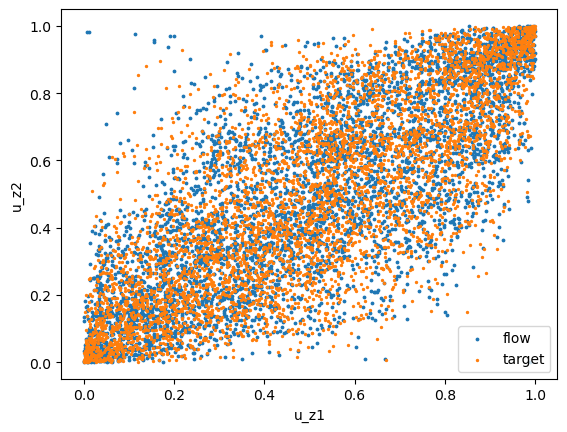

In [321]:
plt.scatter(*copula_flow_samples[:,1:].T, label="flow", s=3)
plt.scatter(*u_x.T, label="target", s=2)
plt.xlabel('u_z1')
plt.ylabel('u_z2')
plt.legend()
plt.show()

In [306]:
# y_degen = y_samples[y_samples == -jnp.inf]
# len(y_degen)
# y_nondegen = y_samples[y_samples != -jnp.inf]
# len(y_nondegen)

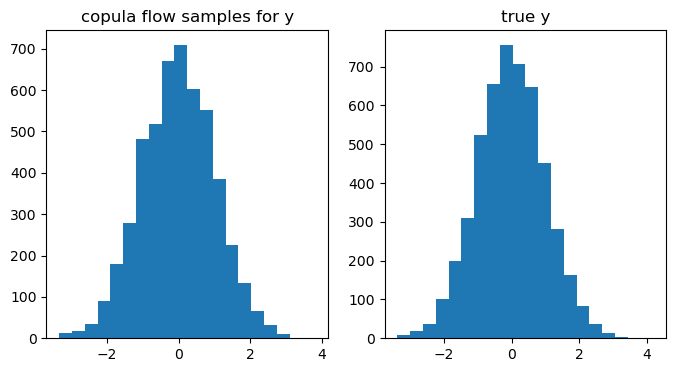

In [322]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(copula_flow_samples[:,0], label="flow", bins=20)
ax[0].set_title('copula flow samples for y')

ax[1].hist(y.flatten(), label="flow", bins=20)
ax[1].set_title('true y')
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

In [323]:
copula_flow.bijection.bijections[-1].bijection.bijections[0].ate, copula_flow.bijection.bijections[-1].bijection.bijections[0].scale

(Array(-0.00547904, dtype=float32), Array(1.0067974, dtype=float32))

In [147]:
n_samples = 10000
y_samples_1 = copula_flow.sample(key, condition=jnp.ones((n_samples,1)))[:,2]
y_samples_0 = copula_flow.sample(key, condition=jnp.zeros((n_samples,1)))[:,2]

In [148]:
y_samples_1.mean(), y_samples_0.mean()

(Array(1.0811653, dtype=float32), Array(-0.06213683, dtype=float32))

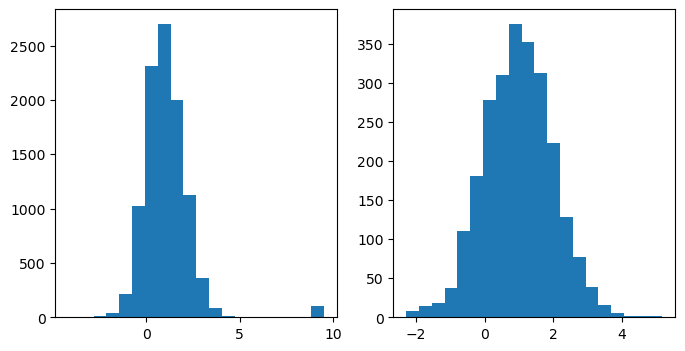

In [149]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(y_samples_1, label="flow", bins=20)
ax[1].hist(y[x==1], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

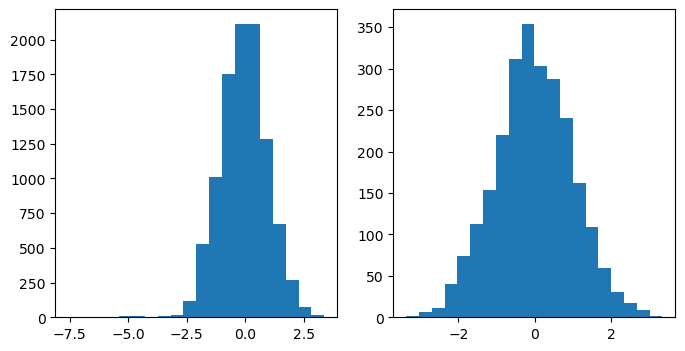

In [150]:
fig,ax =plt.subplots(1,2, figsize=(8,4))
ax[0].hist(y_samples_0, label="flow", bins=20)
ax[1].hist(y[x==0], label="flow", bins=20)
# sns.kdeplot(yy,  color='red', ax=ax[1])
plt.show()

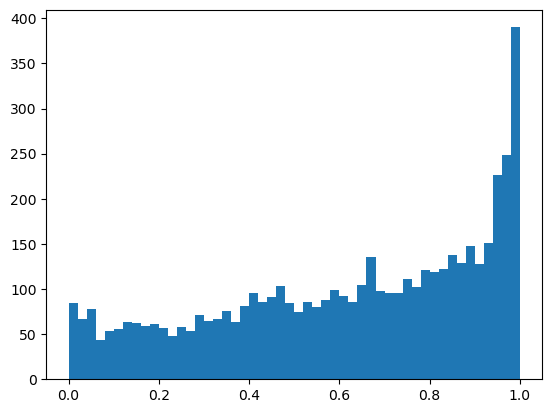

In [120]:
plt.hist(jax.scipy.stats.norm.cdf(y_nondegen, loc=0., scale=1.), bins=50);

### pushing base distribution through the flow

In [324]:
uni_s = jr.uniform(key, shape=(5000,3))

In [325]:
uni_m1p1 = jax.vmap(copula_flow.bijection.bijections[0].tree.transform)(uni_s)
corruni_m1p1 = jax.vmap(copula_flow.bijection.bijections[1].transform)(uni_m1p1) #, u_1)#, x)

In [326]:
corruni_01 = jax.vmap(copula_flow.bijection.bijections[2].tree.transform)(corruni_m1p1) #, u_1) #, x)

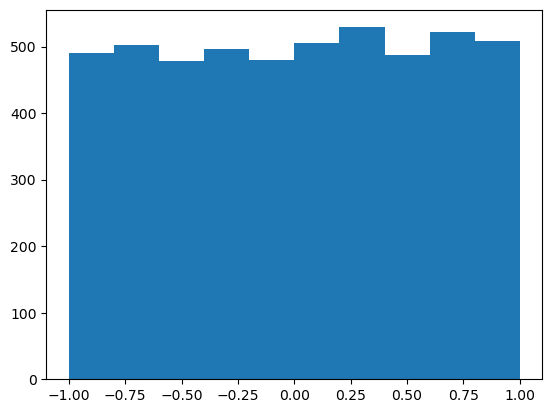

In [327]:
plt.hist(corruni_m1p1[:,0]);

# MLE with bounded base distribution

### Description

I have started using your package and am playing iwth your Bounded Flow example. \
I am using MAF with a rational quadratic spline transformer and want to use a standard uniform as a base distribution. If I simulate $x$ from a standard gaussian and train the flow with MLE, I immediately get an infinite loss and samples from the flow do not correctly recover the target.\
This happens as well if I use a Uniform with a larger support. I have as well tried to build an "unbounded uniform" class for my base distribution where I pass uniform samples through an inverse tanh the same way you do in the example, but I get the same behavior. I would like to know whether there is any workaround to this or this is expected and I am doing something wrong. Thank you for the help and all the good work!

In [25]:
class UnboundedUniform(AbstractTransformed):
    base_dist: flowjax.distributions._StandardUniform
    bijection: Chain

    def __init__(self, shape):
        eps = 1e-7 
        self.base_dist = flowjax.distributions._StandardUniform(shape)
        affine_transformation = Affine(loc=-jnp.ones(shape) + eps, scale=(1 - eps) * jnp.ones(shape)*2)
        inverse_tanh_transformation = Invert(Tanh(shape=shape))
        self.bijection = Chain([affine_transformation, inverse_tanh_transformation])

In [5]:
class modified_StandardUniform(AbstractDistribution):
    r"""Standard Uniform distribution."""

    shape: tuple[int, ...] = ()
    cond_shape: ClassVar[None] = None

    def _log_prob(self, x, condition=None):
        # return jstats.uniform.logpdf(x).sum()
        return 0
        
    def _sample(self, key, condition=None):
        return jr.uniform(key, shape=self.shape)


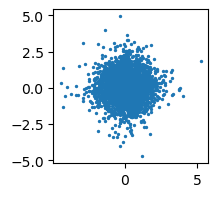

In [8]:
cuni = UnboundedUniform((nvars,))
cuni_sample = cuni.sample(key,sample_shape=(4000,))
plt.figure(figsize=(2,2))
plt.scatter(cuni_sample[:,0], cuni_sample[:,1], s=2)
plt.show()

In [22]:
untrained_flow.sample(subkeys[0], (x.shape[0],))

Array([[-0.69183946, -1.2050312 ],
       [-0.16920964, -0.38235345],
       [-0.28927612, -0.7497571 ],
       ...,
       [ 0.13132116, -0.60346836],
       [ 0.23300245,  0.53565586],
       [ 2.054516  ,  0.9716918 ]], dtype=float32)

In [24]:
untrained_flow.log_prob(x).sum()

Array(-15542.141, dtype=float32)

In [26]:
nvars = 2
key, x_key = jr.split(jr.PRNGKey(0))
x = jr.normal(x_key, shape=(5000, nvars))  
# x = jr.beta(x_key, a=0.4, b=0.4, shape=(5000, nvars)) 

key, subkey = jr.split(jr.PRNGKey(0))
# base_distr = flowjax.distributions._StandardUniform((nvars,))
# base_distr = Uniform(minval=jnp.ones(nvars)*-1, maxval=jnp.ones(nvars)*1)
base_distr = UnboundedUniform((nvars,))
# base_distr = modified_StandardUniform((nvars,))


# Create the flow
untrained_flow = masked_autoregressive_flow(
    key=subkey,
    base_dist=base_distr,#Normal(jnp.zeros(x.shape[1])), #
    transformer=RationalQuadraticSpline(knots=8, interval=4),#Affine(),
    flow_layers=8,
    nn_width=50,
    nn_depth=1,
)

In [27]:
untrained_flow = untrained_flow.merge_transforms()

In [ ]:
untrained_flow = eqx.tree_at(
    where=lambda untrained_flow: untrained_flow.bijection.bijections[0],
    pytree=untrained_flow,
    replace_fn=NonTrainable,
    )

In [33]:
key, subkey = jr.split(key)

# Train on the unbounded space
flow, losses = fit_to_data(
    key=subkey,
    dist=untrained_flow,
    x=x,
    learning_rate=1e-3,
    max_patience=10,
    max_epochs=70,
    return_best=False,
    batch_size=5000,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.19it/s, train=2.8289676, val=2.8443718]


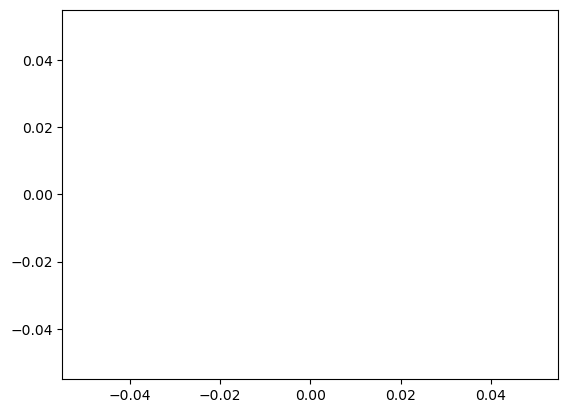

In [34]:
import matplotlib.pyplot as plt

x_degen = x[flow.log_prob(x) == -jnp.inf]
x_nondegen = x[flow.log_prob(x) != -jnp.inf]
plt.scatter(x_degen[:,0], x_degen[:,1], s=3);

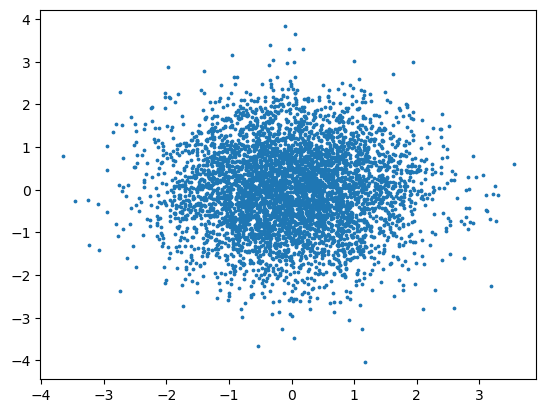

In [35]:
plt.scatter(x_nondegen[:,0], x_nondegen[:,1], s=3);

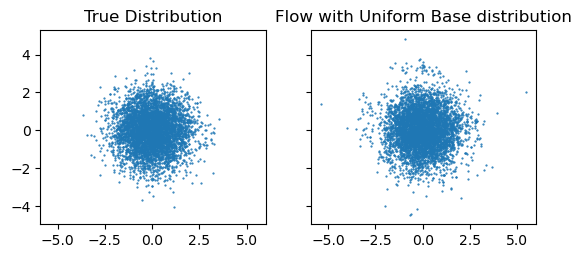

In [36]:
key, *subkeys = jr.split(key, 2)
samples = {
    "True Distribution": x,
    "Flow with Uniform Base distribution": flow.sample(subkeys[0], (x.shape[0],)),
}

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

for (k, v), ax in zip(samples.items(), axes, strict=True):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect("equal")

# ax.set_xlim((-0.2, 1.2))
# ax.set_ylim((-0.2, 1.2))
plt.show()

In [133]:
class UnboundedUniform(AbstractTransformed):
    base_dist: flowjax.distributions._StandardUniform
    bijection: Chain

    def __init__(self, shape):
        eps = 1e-7 
        self.base_dist = flowjax.distributions._StandardUniform(shape)
        affine_transformation = Affine(loc=-jnp.ones(shape) + eps, scale=(1 - eps) * jnp.ones(shape)*2)
        inverse_tanh_transformation = Invert(Tanh(shape=shape))
        self.bijection = Chain([affine_transformation, inverse_tanh_transformation])

In [157]:
minn=-3
maxx=3
nvars = 2

In [158]:
uni = Uniform(minval=jnp.ones(nvars)*minn, maxval=jnp.ones(nvars)*maxx)
uni

Uniform(
  base_dist=_StandardUniform(shape=(2,)),
  bijection=Affine(
    shape=(2,),
    loc=f32[2],
    scale=BijectionReparam(
      _dummy=f32[],
      arr=f32[2],
      bijection=SoftPlus(shape=())
    )
  )
)

In [159]:
cuni = CustomUniform((nvars,))
cuni

CustomUniform(
  base_dist=_StandardUniform(shape=(2,)),
  bijection=Chain(
    shape=(2,),
    cond_shape=None,
    bijections=(
      Affine(
        shape=(2,),
        loc=f32[2],
        scale=BijectionReparam(
          _dummy=f32[],
          arr=f32[2],
          bijection=SoftPlus(shape=())
        )
      ),
      Invert(bijection=Tanh(shape=(2,)))
    )
  )
)

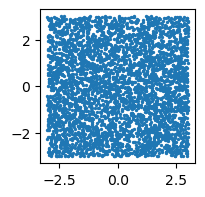

In [167]:
uni.log_prob(jnp.array([2,1]))
uni_sample = uni.sample(key,sample_shape=(4000,))
plt.figure(figsize=(2,2))
plt.scatter(uni_sample[:,0], uni_sample[:,1], s=2)
plt.show()

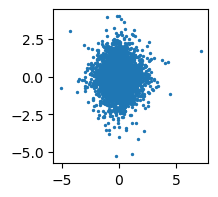

In [165]:
cuni.log_prob(jnp.array([2,1]))
cuni_sample = cuni.sample(key,sample_shape=(4000,))
plt.figure(figsize=(2,2))
plt.scatter(cuni_sample[:,0], cuni_sample[:,1], s=2)
plt.show()

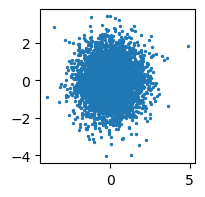

In [168]:
normm = Normal(jnp.zeros(nvars))
normm_sample = normm.sample(key,sample_shape=(4000,))
plt.figure(figsize=(2,2))
plt.scatter(normm_sample[:,0], normm_sample[:,1], s=2)
plt.show()

In [118]:
nvars = 2

In [138]:
nvars = 2
key, x_key = jr.split(jr.PRNGKey(0))
x = jr.normal(x_key, shape=(5000, nvars))  # Supported on the interval [0, 1]^2


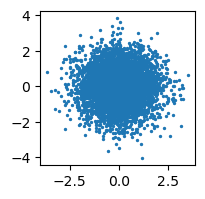

In [139]:
plt.figure(figsize=(2,2))
plt.scatter(x[:,0], x[:,1], s=2)
plt.show()

In [97]:
minn=-3
maxx=3

In [188]:
# base_distr = Uniform(minval=jnp.ones(x.shape[1])*minn, maxval=jnp.ones(x.shape[1])*maxx)
base_distr = CustomUniform((nvars,))

In [189]:
base_distr.log_prob(jnp.array([1., 5]))

Array(-10.867652, dtype=float32)

In [190]:
normm

Normal(
  base_dist=StandardNormal(shape=(2,)),
  bijection=Affine(
    shape=(2,),
    loc=f32[2],
    scale=BijectionReparam(
      _dummy=f32[],
      arr=f32[2],
      bijection=SoftPlus(shape=())
    )
  )
)

In [191]:
base_distr.sample(key)

Array([0.79022765, 0.06094576], dtype=float32)

In [192]:
# eps = 1e-7  # Avoid potential numerical issues

# preprocess = Chain(
#     [
#         Affine(
#             loc=-jnp.ones(2) + eps, scale=(1 - eps) * jnp.array([2, 2]),
#         ),  # [-1+eps, 1-eps]
#         Invert(Tanh(shape=(2,))),  # arctanh (to unbounded)
#     ],
# )

# u_preprocessed = jax.vmap(preprocess.transform)(base_distr)

In [193]:
key, subkey = jr.split(jr.PRNGKey(0))

# Create the flow
untrained_flow = masked_autoregressive_flow(
    key=subkey,
    base_dist=base_distr,#Normal(jnp.zeros(x.shape[1])), #
    transformer=RationalQuadraticSpline(knots=8, interval=4),#Affine(),
)

In [194]:
key, subkey = jr.split(key)

# Train on the unbounded space
flow, losses = fit_to_data(
    key=subkey,
    dist=untrained_flow,
    x=x,
    learning_rate=5e-4,
    max_patience=10,
    max_epochs=70,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:18<00:00,  3.74it/s, train=inf, val=inf]


In [195]:
losses

{'train': [Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Array(inf, dtype=float32),
  Arr

In [150]:
flow.sample(subkeys[0], (x.shape[0],))

Array([[-7.9711924, -8.115033 ],
       [-8.317766 , -8.115033 ],
       [-7.8596206, -8.317766 ],
       ...,
       [-8.317766 , -8.115033 ],
       [-7.9711924, -8.317766 ],
       [-8.115033 , -7.9711924]], dtype=float32)

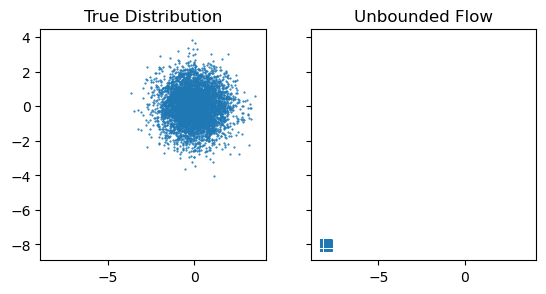

In [151]:
key, *subkeys = jr.split(key, 2)
samples = {
    "True Distribution": x,
    "Flow with Uniform Base": flow.sample(subkeys[0], (x.shape[0],)),
}

fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

for (k, v), ax in zip(samples.items(), axes, strict=True):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect("equal")

# ax.set_xlim((-0.2, 1.2))
# ax.set_ylim((-0.2, 1.2))
plt.show()

# MLE with bounded data

In [3]:
key, x_key = jr.split(jr.PRNGKey(0))
x = jr.beta(x_key, a=0.4, b=0.4, shape=(5000, 2))  # Supported on the interval [0, 1]^2

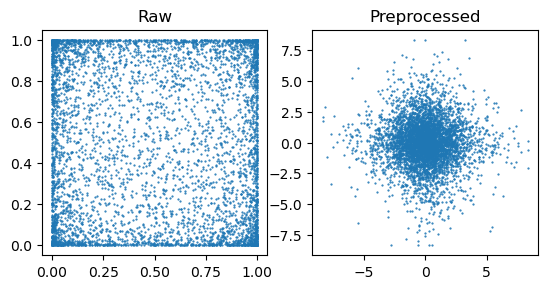

In [7]:
eps = 1e-7  # Avoid potential numerical issues

preprocess = Chain(
    [
        Affine(
            loc=-jnp.ones(2) + eps, scale=(1 - eps) * jnp.array([2, 2]),
        ),  # [-1+eps, 1-eps]
        Invert(Tanh(shape=(2,))),  # arctanh (to unbounded)
    ],
)

x_preprocessed = jax.vmap(preprocess.transform)(x)

# Plot the data
fig, axes = plt.subplots(ncols=2)
plot_data = {"Raw": x, "Preprocessed": x_preprocessed}
for (k, v), ax in zip(plot_data.items(), axes, strict=True):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect("equal")

In [14]:
x.shape[1]

2

In [20]:
Normal(jnp.zeros((5000,2))).sample(jr.PRNGKey(5)).shape

(5000, 2)

In [19]:
x.shape

(5000, 2)

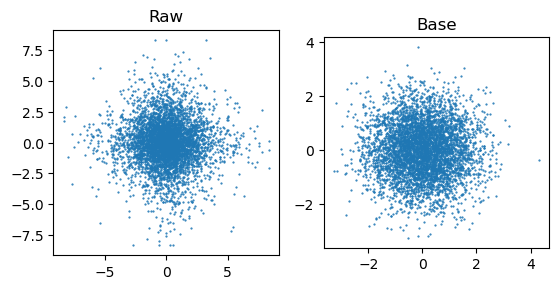

In [24]:
# Plot the data
fig, axes = plt.subplots(ncols=2)
plot_data = {"Raw": x_preprocessed, "Base": Normal(jnp.zeros((5000,2))).sample(jr.PRNGKey(5))}
for (k, v), ax in zip(plot_data.items(), axes, strict=True):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect("equal")

In [25]:
key, subkey = jr.split(jr.PRNGKey(0))

# Create the flow
untrained_flow = masked_autoregressive_flow(
    key=subkey,
    base_dist=Normal(jnp.zeros(x.shape[1])),
    transformer=Affine(),
)

In [27]:
key, subkey = jr.split(key)

# Train on the unbounded space
flow, losses = fit_to_data(
    key=subkey,
    dist=untrained_flow,
    x=x_preprocessed,
    learning_rate=5e-3,
    max_patience=10,
    max_epochs=70,
)

# Transform flow back to bounded space
flow = Transformed(flow, Invert(preprocess))

 40%|████████████████████████████████████▊                                                       | 28/70 [00:04<00:07,  5.76it/s, train=4.068973, val=4.0827928 (Max patience reached)]


In [28]:
naive_flow, losses = fit_to_data(
    subkey, untrained_flow, x, learning_rate=5e-3, max_patience=10, max_epochs=70,
)

 53%|███████████████████████████████████████████████▌                                          | 37/70 [00:04<00:03,  8.43it/s, train=0.32083103, val=0.2605726 (Max patience reached)]


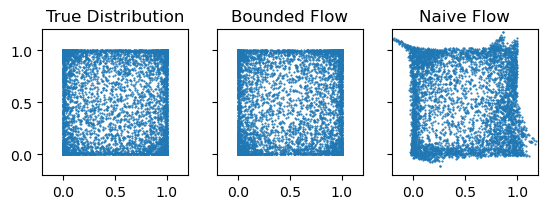

In [29]:
key, *subkeys = jr.split(key, 3)
samples = {
    "True Distribution": x,
    "Bounded Flow": flow.sample(subkeys[0], (x.shape[0],)),
    "Naive Flow": naive_flow.sample(subkeys[1], (x.shape[0],)),
}

fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True)

for (k, v), ax in zip(samples.items(), axes, strict=True):
    ax.scatter(v[:, 0], v[:, 1], s=0.3)
    ax.set_title(k)
    ax.set_aspect("equal")

ax.set_xlim((-0.2, 1.2))
ax.set_ylim((-0.2, 1.2))
plt.show()

# Univariate case

In [13]:
from collections.abc import Callable, Sequence
from functools import partial
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import optax
from jax import Array, jit
from tqdm import tqdm

PyTree = Any

In [14]:
def step(
    params: PyTree,
    static: PyTree,
    *args,
    optimizer: optax.GradientTransformation,
    opt_state: PyTree,
    loss_fn: Callable,
):
    """Carry out a training step.

    Args:
        params: Parameters for the model
        static: Static components of the model.
        *args: Arguments passed to the loss function.
        optimizer: Optax optimizer.
        opt_state: Optimizer state.
        loss_fn: The loss function. This should take params and static as the first two
            arguments.

    Returns:
        tuple: (params, opt_state, loss_val)
    """
    loss_val, grads = eqx.filter_value_and_grad(loss_fn)(params, static, *args)
    updates, opt_state = optimizer.update(grads, opt_state, params=params)
    params = eqx.apply_updates(params, updates)
    return params, opt_state, loss_val

In [17]:
# train val split
max_epochs = 70
show_progress = True
key, subkey = jr.split(key)
train_data = x
losses = []

loop = tqdm(range(max_epochs), disable=not show_progress)

for _ in loop:
    # Shuffle data
    key, *subkeys = jr.split(key, 3)
    train_data = [jr.permutation(subkeys[0], a) for a in train_data]

    # Train epoch
    batch_losses = []
    for batch in zip(*get_batches(train_data, batch_size), strict=True):
        params, opt_state, loss_i = step(
            params,
            static,
            *batch,
            optimizer=optimizer,
            opt_state=opt_state,
            loss_fn=loss_fn,
        )
        batch_losses.append(loss_i)
    losses.append(sum(batch_losses) / len(batch_losses))

  0%|                                                                                                                                                           | 0/70 [00:00<?, ?it/s]


NameError: name 'get_batches' is not defined

In [ ]:
T = TypeVar("T")

def my_f(inut: list[T]) -> tuple[T,T]:
    return (inut[0], inut[-1])

def my_f[T, ](inut: list[T]) -> T:
    return inut[0]
